### Importing libraries

In [15]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import os
import wandb #hyperparameter optimization
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost.sklearn import XGBModel
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression

#seaborn plotting style elements
sns.set_style("whitegrid")
sns.set_palette("colorblind")

### Importing Data

In [17]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test_updated.csv")

### Observing and Cleaning Data

In [18]:
df_train.describe()
#sns.boxplot(df_train.price)

,id,price,construction_year,latitude,longitude,energy_efficiency,expenses,floor,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
count,46312.000000,4.631200e+04,32366.000000,46299.000000,46299.000000,2.640900e+04,30158.000000,44281.000000,43896.000000,28869.000000,27963.000000,45959.000000,46299.000000,45869.000000
mean,32960.756132,5.031879e+05,1958.032874,43.534743,11.451295,5.091382e+03,195.285132,2.033333,1.559140,0.952510,5.724207,3.284166,0.994756,114.866620
std,19090.178152,1.106504e+06,72.021035,1.789416,1.502453,7.600521e+05,4035.008418,2.175668,0.769869,0.212689,191.115233,1.329654,0.030093,88.650549
min,0.000000,1.540000e+02,1000.000000,41.690300,9.060775,1.000000e-02,0.000000,-5.000000,1.000000,0.000000,1.000000,1.000000,0.588014,0.000000
25%,16466.500000,1.990000e+05,1950.000000,41.882400,9.221300,1.590000e+02,40.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,68.000000
50%,32906.500000,3.150000e+05,1967.000000,41.960604,12.361864,1.750000e+02,80.000000,2.000000,1.000000,1.000000,4.000000,3.000000,1.000000,91.000000
75%,49489.250000,5.150000e+05,1987.000000,45.465800,12.487604,1.750000e+02,150.000000,3.000000,2.000000,1.000000,6.000000,4.000000,1.000000,130.000000
max,66159.000000,7.200000e+07,2500.000000,45.561298,12.854100,1.234570e+08,346000.000000,56.000000,9.000000,1.000000,31960.000000,9.000000,1.000000,990.000000


In [19]:
df_train.isna().sum()/len(df_train.index)

id                     0.000000
price                  0.000000
balcony                0.333456
conditions             0.026537
construction_year      0.301131
latitude               0.000281
longitude              0.000281
energy_efficiency      0.429759
expenses               0.348808
floor                  0.043855
garden                 0.680795
n_bathrooms            0.052168
elevator               0.376641
total_floors           0.396204
n_rooms                0.007622
proximity_to_center    0.000281
surface                0.009566
dtype: float64

#### First of all, let's drop the rows containing some unrealistic outliers in the price column.

In [20]:
df_train.price.quantile(0.005) # 48750 is a realistic lower bound price for a house
df_train.price.quantile(0.99) # 3300000 is a realistic upper bound price for a house

df_train=df_train[(df_train['price'] >= 48750) & (df_train['price'] <= 3300000)]

In [21]:
df_train.describe() # we lost about 800 of our rows, which is negligible for our model's accuracy.

,id,price,construction_year,latitude,longitude,energy_efficiency,expenses,floor,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
count,45629.000000,4.562900e+04,32033.000000,45616.000000,45616.000000,2.614000e+04,29887.000000,43719.000000,43573.000000,28590.000000,27622.000000,45347.000000,45616.000000,45194.000000
mean,32955.237502,4.350883e+05,1958.518715,43.531795,11.455430,5.131830e+03,193.225951,2.033875,1.552842,0.952186,5.749584,3.278982,0.994707,112.513564
std,19091.926056,4.013144e+05,71.235594,1.789439,1.500603,7.639510e+05,4051.106725,2.173061,0.750495,0.213376,192.291050,1.318351,0.030241,81.276642
min,0.000000,4.875000e+04,1000.000000,41.690300,9.060775,1.000000e-02,0.000000,-5.000000,1.000000,0.000000,1.000000,1.000000,0.588014,0.000000
25%,16451.000000,1.990000e+05,1950.000000,41.881700,9.221563,1.588075e+02,40.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,68.000000
50%,32894.000000,3.100000e+05,1967.000000,41.959894,12.362045,1.750000e+02,80.000000,2.000000,1.000000,1.000000,4.000000,3.000000,1.000000,91.000000
75%,49485.000000,5.000000e+05,1988.000000,45.465800,12.488000,1.750000e+02,150.000000,3.000000,2.000000,1.000000,6.000000,4.000000,1.000000,130.000000
max,66159.000000,3.300000e+06,2500.000000,45.561298,12.854100,1.234570e+08,346000.000000,56.000000,9.000000,1.000000,31960.000000,9.000000,1.000000,970.000000


#### Now, let's handle each column separately:

##### Balcony

In [22]:
df_train.groupby("balcony").count()
#We see that balcony has only taken the value True. So we can assume that the missing values are False.
#In order to be able to include balcony in our model, I swap the values "True" to 1, and the rest to 0.
df_train.balcony = np.where(df_train.balcony == True, 1, 0)

##### Conditions

In [23]:
df_train.groupby("conditions").mean(numeric_only=True)

#seems like we have 4 categories for our conditions column. We divide it into 3 dummy variables
df_train["buono_stato"] = np.where(df_train["conditions"] == "Buono stato / Abitabile",1,0)
df_train["ottimo"] = np.where(df_train["conditions"] == "Ottimo / Ristrutturato",1,0)
df_train["nuovo"] = np.where(df_train["conditions"] == "Nuovo / Nuova costruzione",1,0)
df_train["da_ristrutturare"] = np.where(df_train["conditions"] == "Da ristrutturare",1,0)

#adding another column that indicates whether information is missing or not
df_train["missing_cond"] = np.where(df_train["conditions"].isna(),1,0)

df_train.drop(["conditions"],axis = 1, inplace = True)

##### Construction year

In [24]:
#sns.scatterplot(df_train.construction_year) # a lot of rows with unrealistic construction year
msk = df_train.construction_year <= 1400
df_train[msk] # we have 105 rows with a construction_year lower than 1400, since we have the same problem with the test data, we shall turn them into NaN and then impute them later on.

df_train.construction_year = np.where(msk, np.nan, df_train.construction_year)
msk_future = df_train.construction_year > 2023 # we have 138 rows with a construction year in the future. We do the same treatment.
df_train.construction_year = np.where(msk_future, np.nan, df_train.construction_year)
df_train.describe()

,id,price,balcony,construction_year,latitude,longitude,energy_efficiency,expenses,floor,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,buono_stato,ottimo,nuovo,da_ristrutturare,missing_cond
count,45629.000000,4.562900e+04,45629.000000,31790.000000,45616.000000,45616.000000,2.614000e+04,29887.000000,43719.000000,43573.000000,28590.000000,27622.000000,45347.000000,45616.000000,45194.000000,45629.000000,45629.000000,45629.000000,45629.000000,45629.000000
mean,32955.237502,4.350883e+05,0.669333,1960.532054,43.531795,11.455430,5.131830e+03,193.225951,2.033875,1.552842,0.952186,5.749584,3.278982,0.994707,112.513564,0.471849,0.227158,0.153061,0.122247,0.025685
std,19091.926056,4.013144e+05,0.470458,58.236000,1.789439,1.500603,7.639510e+05,4051.106725,2.173061,0.750495,0.213376,192.291050,1.318351,0.030241,81.276642,0.499212,0.419000,0.360050,0.327574,0.158197
min,0.000000,4.875000e+04,0.000000,1450.000000,41.690300,9.060775,1.000000e-02,0.000000,-5.000000,1.000000,0.000000,1.000000,1.000000,0.588014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16451.000000,1.990000e+05,0.000000,1950.000000,41.881700,9.221563,1.588075e+02,40.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32894.000000,3.100000e+05,1.000000,1967.000000,41.959894,12.362045,1.750000e+02,80.000000,2.000000,1.000000,1.000000,4.000000,3.000000,1.000000,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49485.000000,5.000000e+05,1.000000,1986.000000,45.465800,12.488000,1.750000e+02,150.000000,3.000000,2.000000,1.000000,6.000000,4.000000,1.000000,130.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,66159.000000,3.300000e+06,1.000000,2023.000000,45.561298,12.854100,1.234570e+08,346000.000000,56.000000,9.000000,1.000000,31960.000000,9.000000,1.000000,970.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Latitude and Longitude

In [25]:
# Plotting the scatterplot to identify the cities
#sns.scatterplot(x="longitude", y="latitude", data=df_base)
# We see that all of our locations are piled on 3 clusters. This implies that we only have 3 cities.

# Identifying the three cities by computing the mean latitude and longitude of each cluster
df_train[df_train["longitude"] < 10].mean(numeric_only=True)[["latitude", "longitude"]]  # lat:45.47, long:9.18 (our 1st city)
df_train[df_train["latitude"] < 43].mean(numeric_only=True)[["latitude", "longitude"]]  # lat:41.88, long:12.48 (our 2nd city)
df_train[(df_train["latitude"] > 43) & (df_train["longitude"] > 10)].mean(numeric_only=True)[["latitude", "longitude"]]  # lat:45.46, long:12.3 (our 3rd city)

# Checking from Google Maps, we see that these coordinates correspond to Milan, Rome, and Venice

# We define the coordinates of Venice, Milan, and Rome
venice = [45.4408, 12.3155]
milan = [45.4642, 9.1900]
rome = [41.9028, 12.4964]

# We calculate the Euclidean distance between each row in the dataframe and the cities, only for the rows that have latitude and longitude data

df_train['dist_venice'] = np.sqrt((df_train['latitude'] - venice[0]) ** 2 + (df_train['longitude'] - venice[1]) ** 2)
df_train['dist_milan'] = np.sqrt((df_train['latitude'] - milan[0]) ** 2 + (df_train['longitude'] - milan[1]) ** 2)
df_train['dist_rome'] = np.sqrt((df_train['latitude'] - rome[0]) ** 2 + (df_train['longitude'] - rome[1]) ** 2)


# Find the nearest city for each row
#1111
df_train['city'] = np.where(df_train[['dist_venice', 'dist_milan', 'dist_rome']].idxmin(axis=1) == 'dist_venice',
                            'Venice',
                            (np.where(df_train[['dist_venice', 'dist_milan', 'dist_rome']].idxmin(axis=1) == 'dist_milan', 'Milan', 'Rome')))
df_train.drop(["dist_milan", "dist_venice", "dist_rome"], axis=1, inplace=True)
df_train["in_rome"] = np.where(df_train["city"] == "Rome", 1, 0)
df_train["in_milan"] = np.where(df_train["city"] == "Milan", 1, 0)
df_train["in_venice"] = np.where(df_train["city"] == "Venice", 1, 0)

df_train["missing_loc"] = np.where(df_train["longitude"].isna(), 1, 0)

#to fix the issue where rows that didn't contain information were automatically allocated to rome:
df_train["in_rome"] = np.where(df_train["missing_loc"] == 1, 0, df_train["in_rome"])
df_train.drop(["city","longitude","latitude"], axis =1, inplace = True)





##### Energy Efficiency

Due to the fact that 43% of the data is missing in this column, and that I don't consider it a vital element, I have decided to not include this column.

In [26]:
df_train.drop(["energy_efficiency"], axis = 1, inplace = True)
df_test.drop(["energy_efficiency"], axis = 1, inplace = True)

##### Expenses

In [27]:
df_train.expenses.quantile(0.97) # I am going to swap the unrealistic values To NaN.
df_train.expenses = np.where((df_train.expenses > 400)|(df_train.expenses <20),np.nan,df_train.expenses)

##### Floor

Maximum floor in milan,rome,venice is 31. Also,floors below -1 are not realistic

In [28]:
df_train.floor = np.where((df_train.floor > 25) | (df_train.floor<-1), np.nan, df_train.floor) 
df_train.describe()

,id,price,balcony,construction_year,expenses,floor,n_bathrooms,elevator,total_floors,n_rooms,...,surface,buono_stato,ottimo,nuovo,da_ristrutturare,missing_cond,in_rome,in_milan,in_venice,missing_loc
count,45629.000000,4.562900e+04,45629.000000,31790.000000,23504.000000,43680.000000,43573.000000,28590.000000,27622.000000,45347.000000,...,45194.000000,45629.000000,45629.000000,45629.000000,45629.000000,45629.000000,45629.000000,45629.000000,45629.000000,45629.000000
mean,32955.237502,4.350883e+05,0.669333,1960.532054,115.988768,2.035806,1.552842,0.952186,5.749584,3.278982,...,112.513564,0.471849,0.227158,0.153061,0.122247,0.025685,0.539657,0.302636,0.157422,0.000285
std,19091.926056,4.013144e+05,0.470458,58.236000,79.014031,2.151723,0.750495,0.213376,192.291050,1.318351,...,81.276642,0.499212,0.419000,0.360050,0.327574,0.158197,0.498430,0.459404,0.364202,0.016877
min,0.000000,4.875000e+04,0.000000,1450.000000,20.000000,-1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16451.000000,1.990000e+05,0.000000,1950.000000,60.000000,1.000000,1.000000,1.000000,3.000000,2.000000,...,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32894.000000,3.100000e+05,1.000000,1967.000000,98.000000,2.000000,1.000000,1.000000,4.000000,3.000000,...,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,49485.000000,5.000000e+05,1.000000,1986.000000,150.000000,3.000000,2.000000,1.000000,6.000000,4.000000,...,130.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,66159.000000,3.300000e+06,1.000000,2023.000000,400.000000,20.000000,9.000000,1.000000,31960.000000,9.000000,...,970.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Garden

It seems we only have the value True for garden. Which makes me think that The values False were not recorded, and are all NaN values. I am going to assume that all None values are 0.

In [29]:
df_train.groupby("garden").count()
df_train.garden = np.where(df_train.garden == True, 1, 0)

##### N_Bathrooms

We have only a few missing values for n_bathrooms, so it is fair to just fill the missing values with the median, 1.

In [30]:
df_train.n_bathrooms = df_train.n_bathrooms.fillna(1.0)

##### Elevator

In [31]:
df_train.elevator = df_train.elevator.fillna(0.0)

##### Total_floors

Maximum floor in milan,rome,venice is 31.

In [32]:
df_train.total_floors = np.where(df_train.total_floors > 31, np.nan, df_train.total_floors)

##### N_rooms

Everything looks good with n_rooms. We are going to impute the missing values later on.

##### Proximity_to_center

Few rows have missing data and the mean is 0.995, while the median is 1. We can transform this column to city_center_distance.

In [33]:
df_train.proximity_to_center = df_train.proximity_to_center.fillna(1.0)
df_train['city_center_distance'] = df_train['proximity_to_center'].apply(lambda x: 0 if x >= 1 else 1/x)
df_train.drop("proximity_to_center", axis = 1,inplace = True)


##### Surface

We have some outliers for this numerical column. In order to deal with them, I will swap the outliers with NaN, and then impute them later on.

In [34]:
df_train.surface.quantile(0.01) #30
df_train.surface.quantile(0.985) #400
df_train.surface = np.where((df_train.surface < 30)|(df_train.surface > 400), np.nan, df_train.surface)

### Clean data visualization

#### Correlation heatmap

<Axes: >

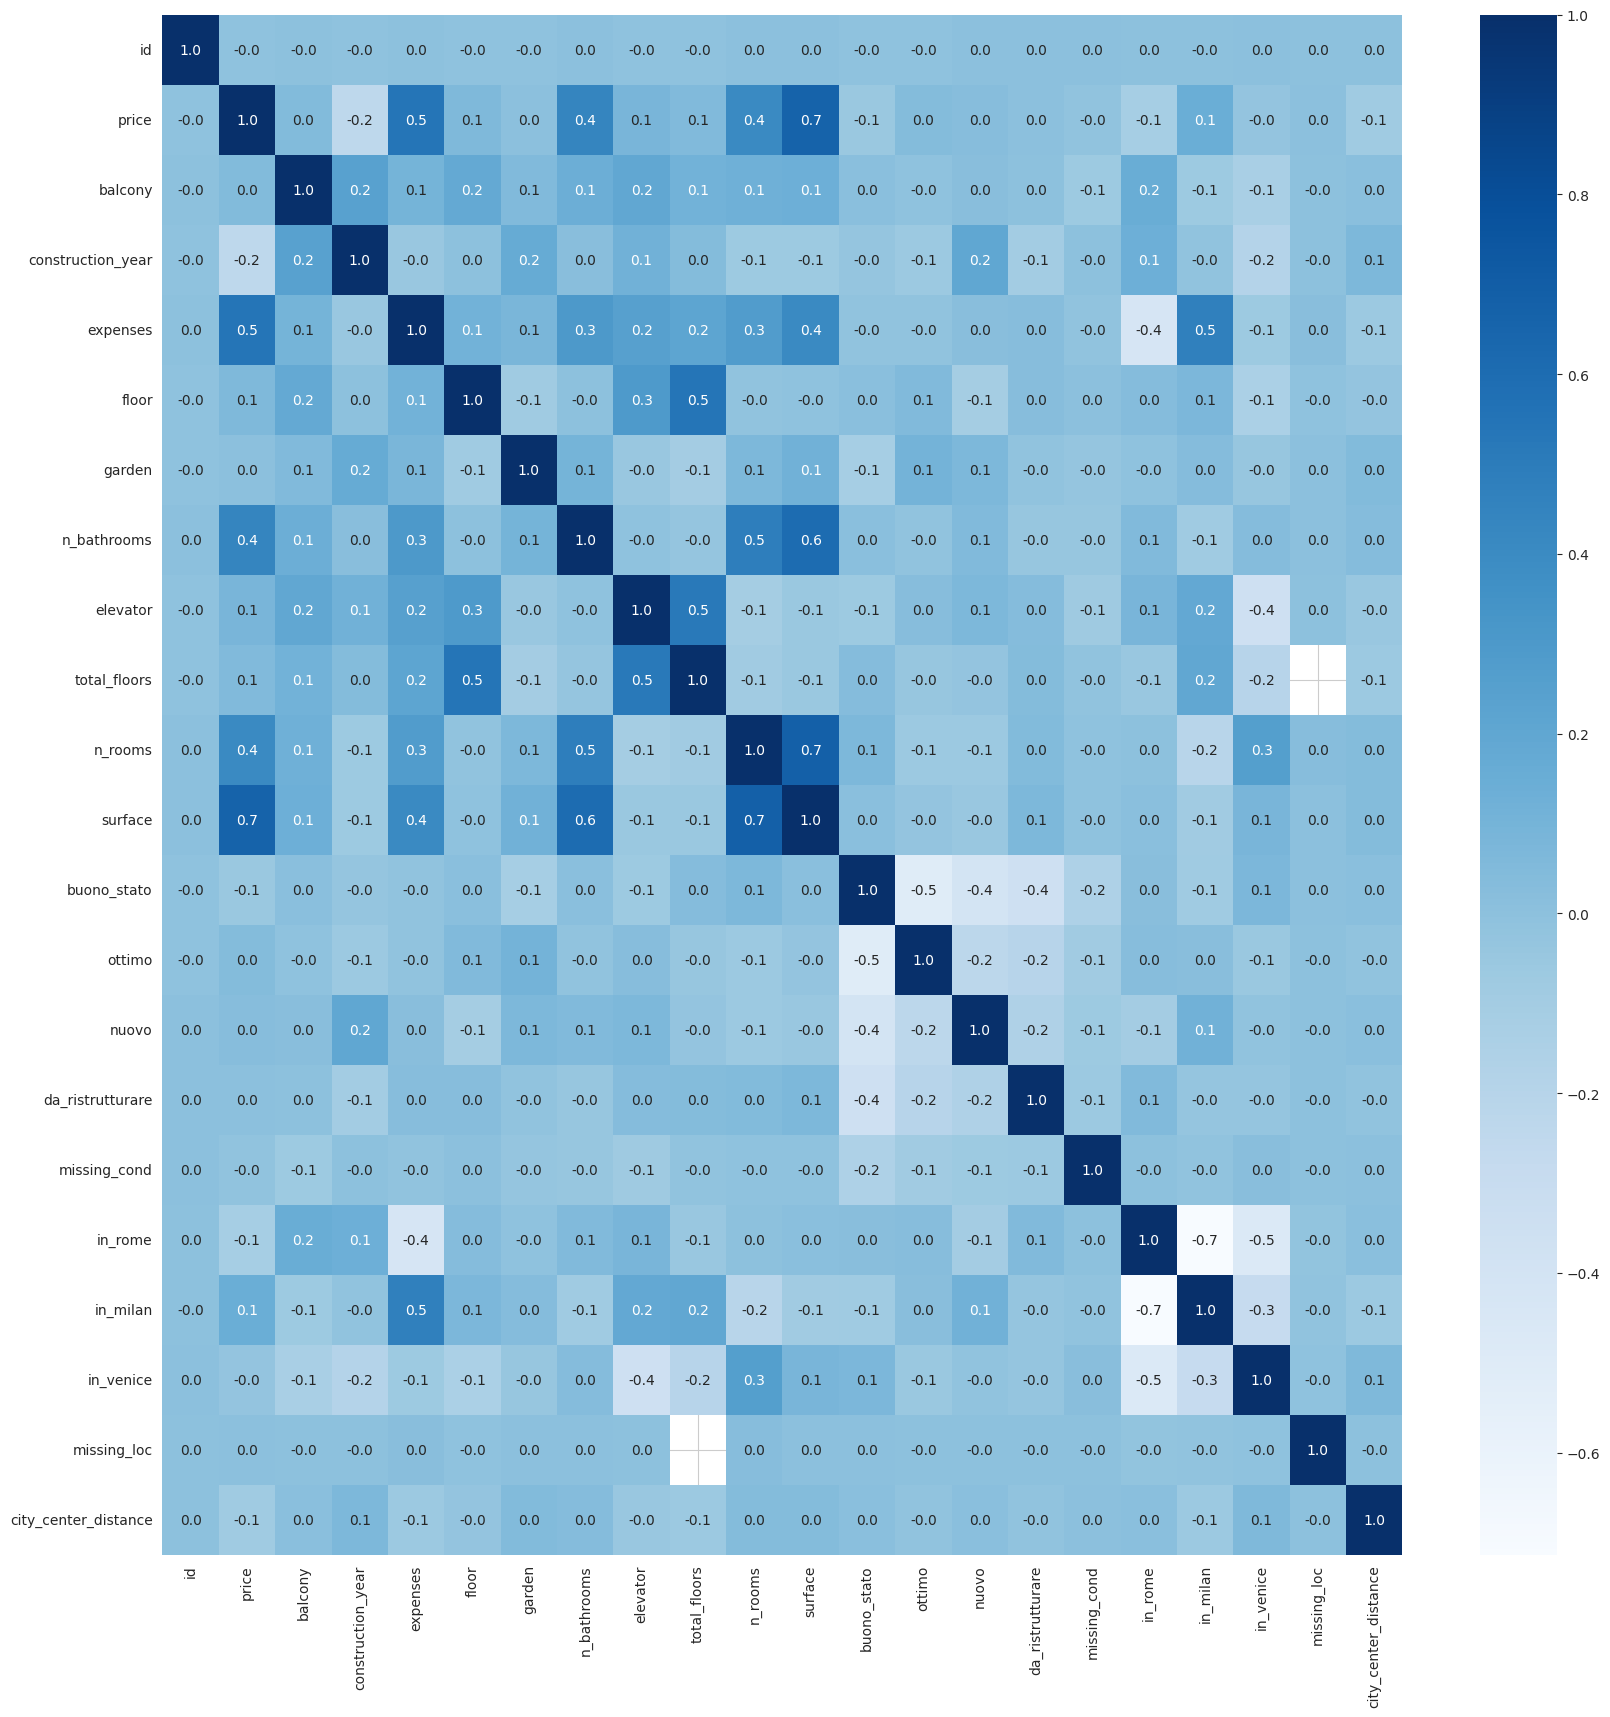

In [35]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_train.corr(numeric_only=True),
            cmap='Blues',
            ax=ax,
            annot=True, 
            fmt='.1f')

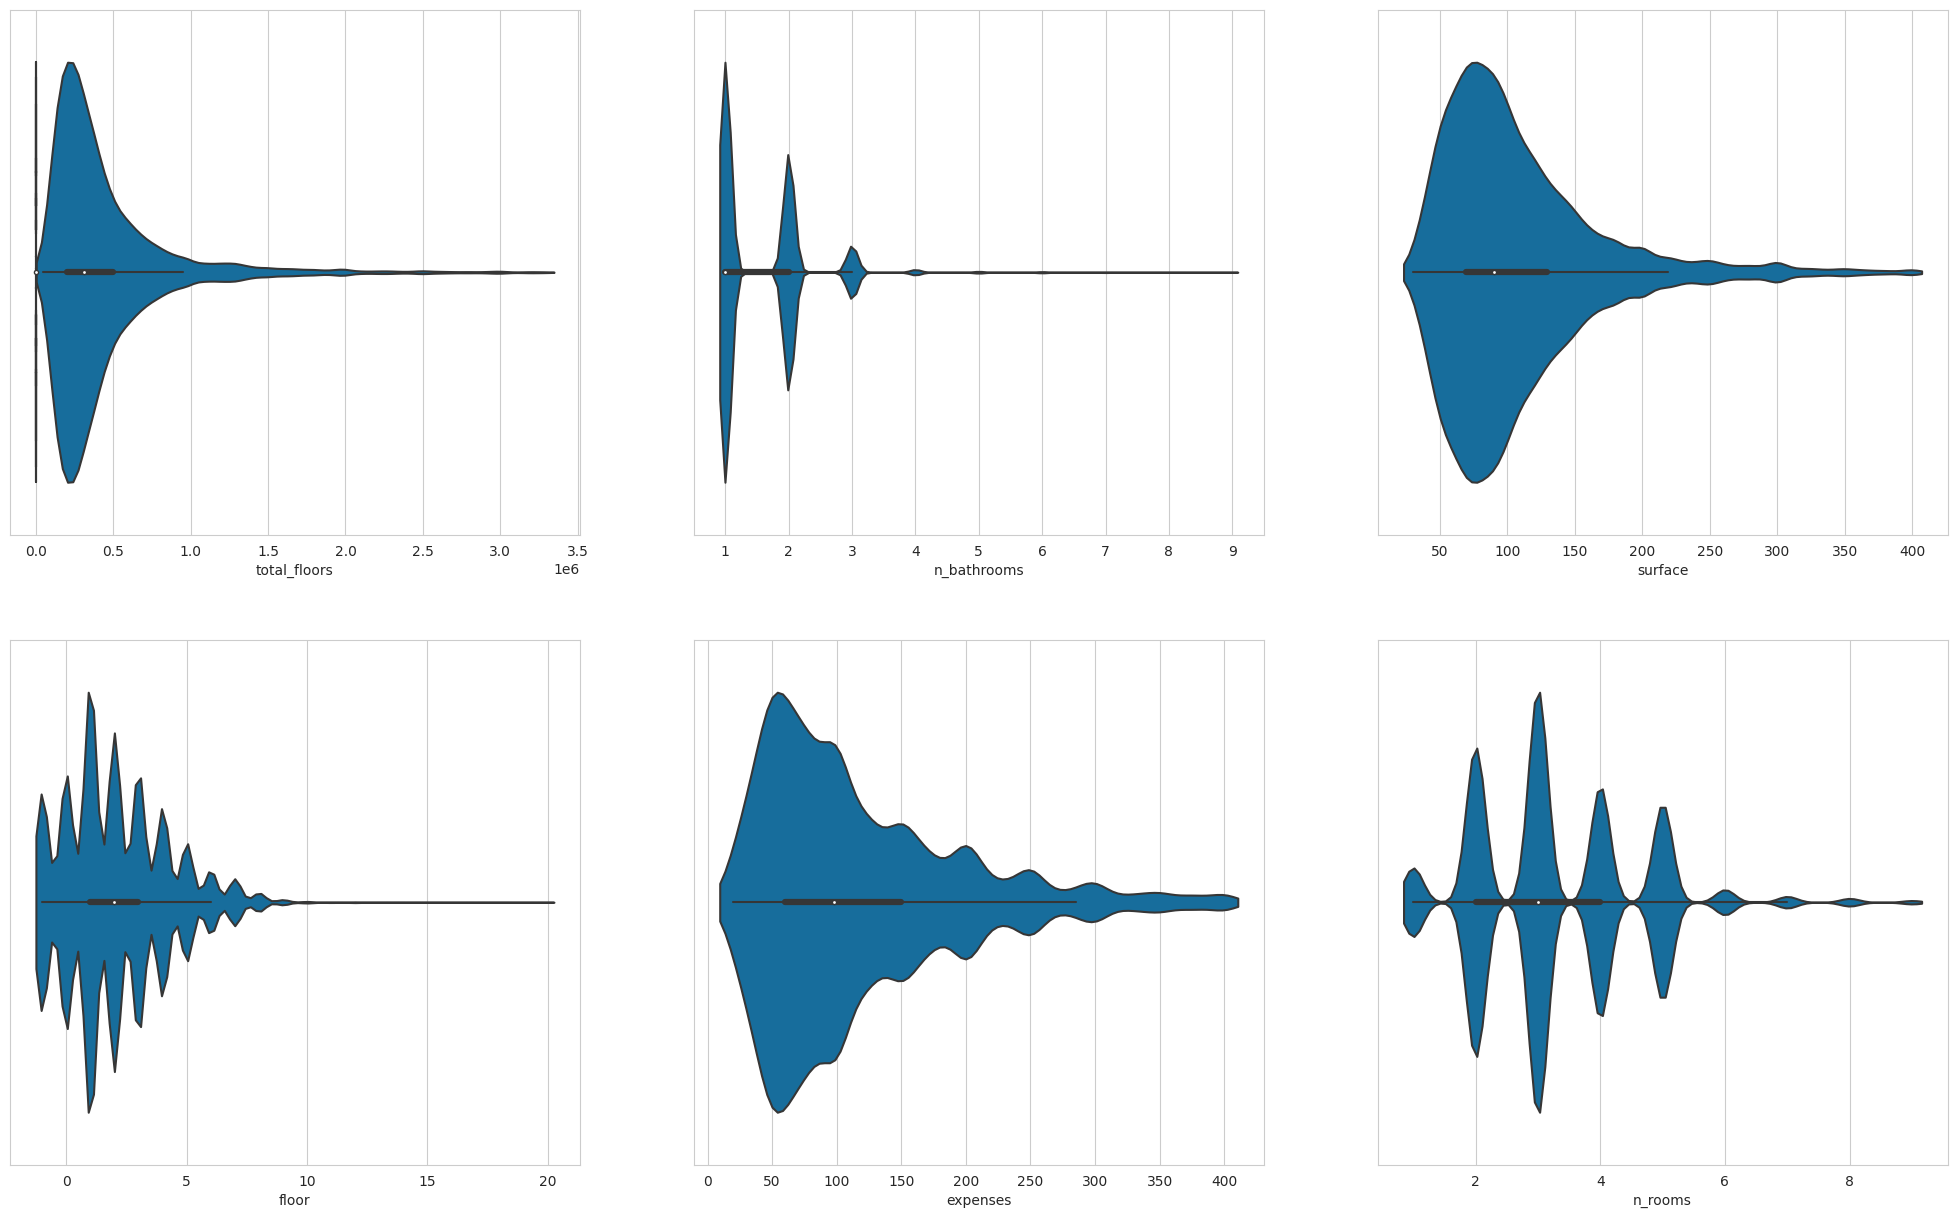

In [36]:
cont_vars = ['price', 'expenses', 'surface', 'floor', 'n_bathrooms', 'n_rooms', "total_floors"]

fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(25,15))
for i, col in enumerate(cont_vars):
  sns.violinplot(data=df_train,
                x=col,
                scale='count',
                ax=ax[i%2,i%3],
                cut=1)

### Imputing the missing values

In [37]:
imputed_df = df_train.copy()
imputed_df.isna().sum()

id                          0
price                       0
balcony                     0
construction_year       13839
expenses                22125
floor                    1949
garden                      0
n_bathrooms                 0
elevator                    0
total_floors            18017
n_rooms                   282
surface                  1384
buono_stato                 0
ottimo                      0
nuovo                       0
da_ristrutturare            0
missing_cond                0
in_rome                     0
in_milan                    0
in_venice                   0
missing_loc                 0
city_center_distance        0
dtype: int64

We are going to impute the columns construction_year, expenses, floor, total_floors, n_rooms and surface. We will impute each column taking into account which other columns they are related to, in order for the noise not to tamper with our imputation.

In [38]:
imp = IterativeImputer(random_state=42,
                      estimator = LinearRegression(), sample_posterior=False,max_iter=10,tol=0.001,
                      n_nearest_features = None, 
                      min_value = [20, -1, 1, 1400, 1, 30, 0, 0, 0, 1, 0], max_value=(450,20,29,2023,9,400,1,1,1,9,1), initial_strategy="mean", imputation_order = "roman")
cols_to_impute = ["expenses", "floor", "total_floors", "construction_year", "n_rooms", "surface", "in_rome", "in_milan", "in_venice", "n_bathrooms", "elevator"]
#The columns to impute together were chosen from the correlation heatmap

imputed_df[cols_to_impute] = imp.fit_transform(imputed_df[cols_to_impute])
#imp.fit(imputed_df[cols_to_impute_together])

#imputed_df[cols_to_impute_together] = imp.transform(imputed_df[cols_to_impute_together])

#Now, I will impute the construction_year based on all the other columns, as it by itself doesn't have direct relationships with other columns.

#imp.fit(imputed_df)
#imputed_df["construction_year"] = imp.transform(imputed_df[["construction_year"]])
#imputed_df.describe()

In [39]:
#Lastly, I change the construction_year column to age column.
imputed_df["age"] = 2023-imputed_df['construction_year']
imputed_df["age"] = (imputed_df["age"] - imputed_df["age"].mean()) / (imputed_df["age"].std())
imputed_df.drop(["construction_year"], axis = 1, inplace = True)

### Cleaning the test data

Now,we apply the same process to test data

In [40]:
df_test.isna().sum()/len(df_test.index) #Similar percentages missing with train data

id                     0.000000
balcony                0.340206
conditions             0.025824
construction_year      0.301395
latitude               0.000505
longitude              0.000505
expenses               0.352284
floor                  0.044269
garden                 0.679351
n_bathrooms            0.048059
elevator               0.376743
total_floors           0.401152
n_rooms                0.007126
proximity_to_center    0.000505
surface                0.008237
dtype: float64

Since we cannot simply drop rows with unrealistic

In [41]:
df_test.groupby("balcony").count()
#We see that balcony has only taken the value True. So we can assume that the missing values are False.
#In order to be able to include balcony in our model, I swap the values "True" to 1, and the rest to 0.
df_test.balcony = np.where(df_test.balcony == True, 1, 0)

In [42]:

df_test["buono_stato"] = np.where(df_test["conditions"] == "Buono stato / Abitabile",1,0)
df_test["ottimo"] = np.where(df_test["conditions"] == "Ottimo / Ristrutturato",1,0)
df_test["nuovo"] = np.where(df_test["conditions"] == "Nuovo / Nuova costruzione",1,0)
df_test["da_ristrutturare"] = np.where(df_test["conditions"] == "Da ristrutturare",1,0)

#adding another column that indicates whether information is missing or not
df_test["missing_cond"] = np.where(df_test["conditions"].isna(),1,0)

df_test.drop(["conditions"],axis = 1, inplace = True)

In [43]:
#sns.scatterplot(df_train.construction_year) # a lot of rows with unrealistic construction year
msk = df_test.construction_year <= 1400
df_test[msk] # we have 105 rows with a construction_year lower than 1400, since we have the same problem with the test data, we shall turn them into NaN and then impute them later on.

df_test.construction_year = np.where(msk, np.nan, df_test.construction_year)
msk_future = df_test.construction_year > 2023
df_test.construction_year = np.where(msk_future, np.nan, df_test.construction_year)
df_test.describe()

,id,balcony,construction_year,latitude,longitude,expenses,floor,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,buono_stato,ottimo,nuovo,da_ristrutturare,missing_cond
count,19788.000000,19788.000000,13706.000000,19778.000000,19778.000000,12817.000000,18912.000000,18837.000000,12333.000000,11850.000000,19647.000000,19778.000000,19625.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000
mean,33365.088589,0.659794,1960.500000,43.563053,11.432657,232.630803,2.003278,1.550512,0.951837,4.593671,3.276785,0.994841,115.136662,0.468163,0.227208,0.156155,0.122650,0.025824
std,19116.407515,0.473790,57.500467,1.791490,1.509342,5586.584917,2.162479,0.758864,0.214120,4.843213,1.328603,0.029679,89.581847,0.498998,0.419039,0.363012,0.328043,0.158613
min,2.000000,0.000000,1495.000000,41.708118,9.061496,0.000000,-5.000000,1.000000,0.000000,1.000000,1.000000,0.590114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16763.500000,0.000000,1950.000000,41.883400,9.219251,40.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33446.500000,1.000000,1967.000000,41.971429,12.358900,80.000000,2.000000,1.000000,1.000000,4.000000,3.000000,1.000000,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,49934.250000,1.000000,1987.750000,45.466800,12.486508,150.000000,3.000000,2.000000,1.000000,6.000000,4.000000,1.000000,130.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,66154.000000,1.000000,2023.000000,45.546407,12.787200,500000.000000,21.000000,9.000000,1.000000,466.000000,9.000000,1.000000,990.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
df_test['dist_venice'] = np.sqrt((df_test['latitude'] - venice[0]) ** 2 + (df_test['longitude'] - venice[1]) ** 2)
df_test['dist_milan'] = np.sqrt((df_test['latitude'] - milan[0]) ** 2 + (df_test['longitude'] - milan[1]) ** 2)
df_test['dist_rome'] = np.sqrt((df_test['latitude'] - rome[0]) ** 2 + (df_test['longitude'] - rome[1]) ** 2)


# Find the nearest city for each row
#1111
df_test['city'] = np.where(df_test[['dist_venice', 'dist_milan', 'dist_rome']].idxmin(axis=1) == 'dist_venice',
                            'Venice',
                            (np.where(df_test[['dist_venice', 'dist_milan', 'dist_rome']].idxmin(axis=1) == 'dist_milan', 'Milan', 'Rome')))
df_test.drop(["dist_milan", "dist_venice", "dist_rome"], axis=1, inplace=True)
df_test["in_rome"] = np.where(df_test["city"] == "Rome", 1, 0)
df_test["in_milan"] = np.where(df_test["city"] == "Milan", 1, 0)
df_test["in_venice"] = np.where(df_test["city"] == "Venice", 1, 0)

df_test["missing_loc"] = np.where(df_test["longitude"].isna(), 1, 0)

#to fix the issue where rows that didn't contain information were automatically allocated to rome:
df_test["in_rome"] = np.where(df_test["missing_loc"] == 1, 0, df_test["in_rome"])
df_test.drop(["city","longitude","latitude"], axis =1, inplace = True)



In [45]:
df_test.expenses.quantile(0.97) # I am going to swap the unrealistic values To NaN.
df_test.expenses = np.where((df_test.expenses > 450)|(df_test.expenses <20),np.nan,df_test.expenses)

In [46]:
df_test.floor = np.where((df_test.floor > 25) | (df_test.floor<-1), np.nan, df_test.floor) 
df_test.describe()

,id,balcony,construction_year,expenses,floor,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface,buono_stato,ottimo,nuovo,da_ristrutturare,missing_cond,in_rome,in_milan,in_venice,missing_loc
count,19788.000000,19788.000000,13706.000000,10050.000000,18890.000000,18837.000000,12333.000000,11850.000000,19647.000000,19778.000000,19625.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000
mean,33365.088589,0.659794,1960.500000,118.971244,2.008364,1.550512,0.951837,4.593671,3.276785,0.994841,115.136662,0.468163,0.227208,0.156155,0.122650,0.025824,0.530928,0.309379,0.159187,0.000505
std,19116.407515,0.473790,57.500467,83.445747,2.158433,0.758864,0.214120,4.843213,1.328603,0.029679,89.581847,0.498998,0.419039,0.363012,0.328043,0.158613,0.499055,0.462249,0.365860,0.022475
min,2.000000,0.000000,1495.000000,20.000000,-1.000000,1.000000,0.000000,1.000000,1.000000,0.590114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16763.500000,0.000000,1950.000000,60.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33446.500000,1.000000,1967.000000,100.000000,2.000000,1.000000,1.000000,4.000000,3.000000,1.000000,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,49934.250000,1.000000,1987.750000,150.000000,3.000000,2.000000,1.000000,6.000000,4.000000,1.000000,130.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,66154.000000,1.000000,2023.000000,450.000000,21.000000,9.000000,1.000000,466.000000,9.000000,1.000000,990.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
df_test.groupby("garden").count() # The same situation with the train data
df_test.garden = np.where(df_test.garden == True, 1, 0)

In [48]:
df_test.n_bathrooms = df_test.n_bathrooms.fillna(1.0)

In [49]:
df_test.elevator = df_test.elevator.fillna(0.0)

In [50]:
df_test.total_floors = np.where(df_test.total_floors > 31, np.nan, df_test.total_floors)

In [51]:
df_test.proximity_to_center = df_test.proximity_to_center.fillna(1.0)
df_test['city_center_distance'] = df_test['proximity_to_center'].apply(lambda x: 0 if x >= 1 else 1/x)
df_test.drop("proximity_to_center", axis = 1,inplace = True)

In [52]:
df_test.surface = np.where((df_test.surface < 30)|(df_test.surface > 450), np.nan, df_test.surface)

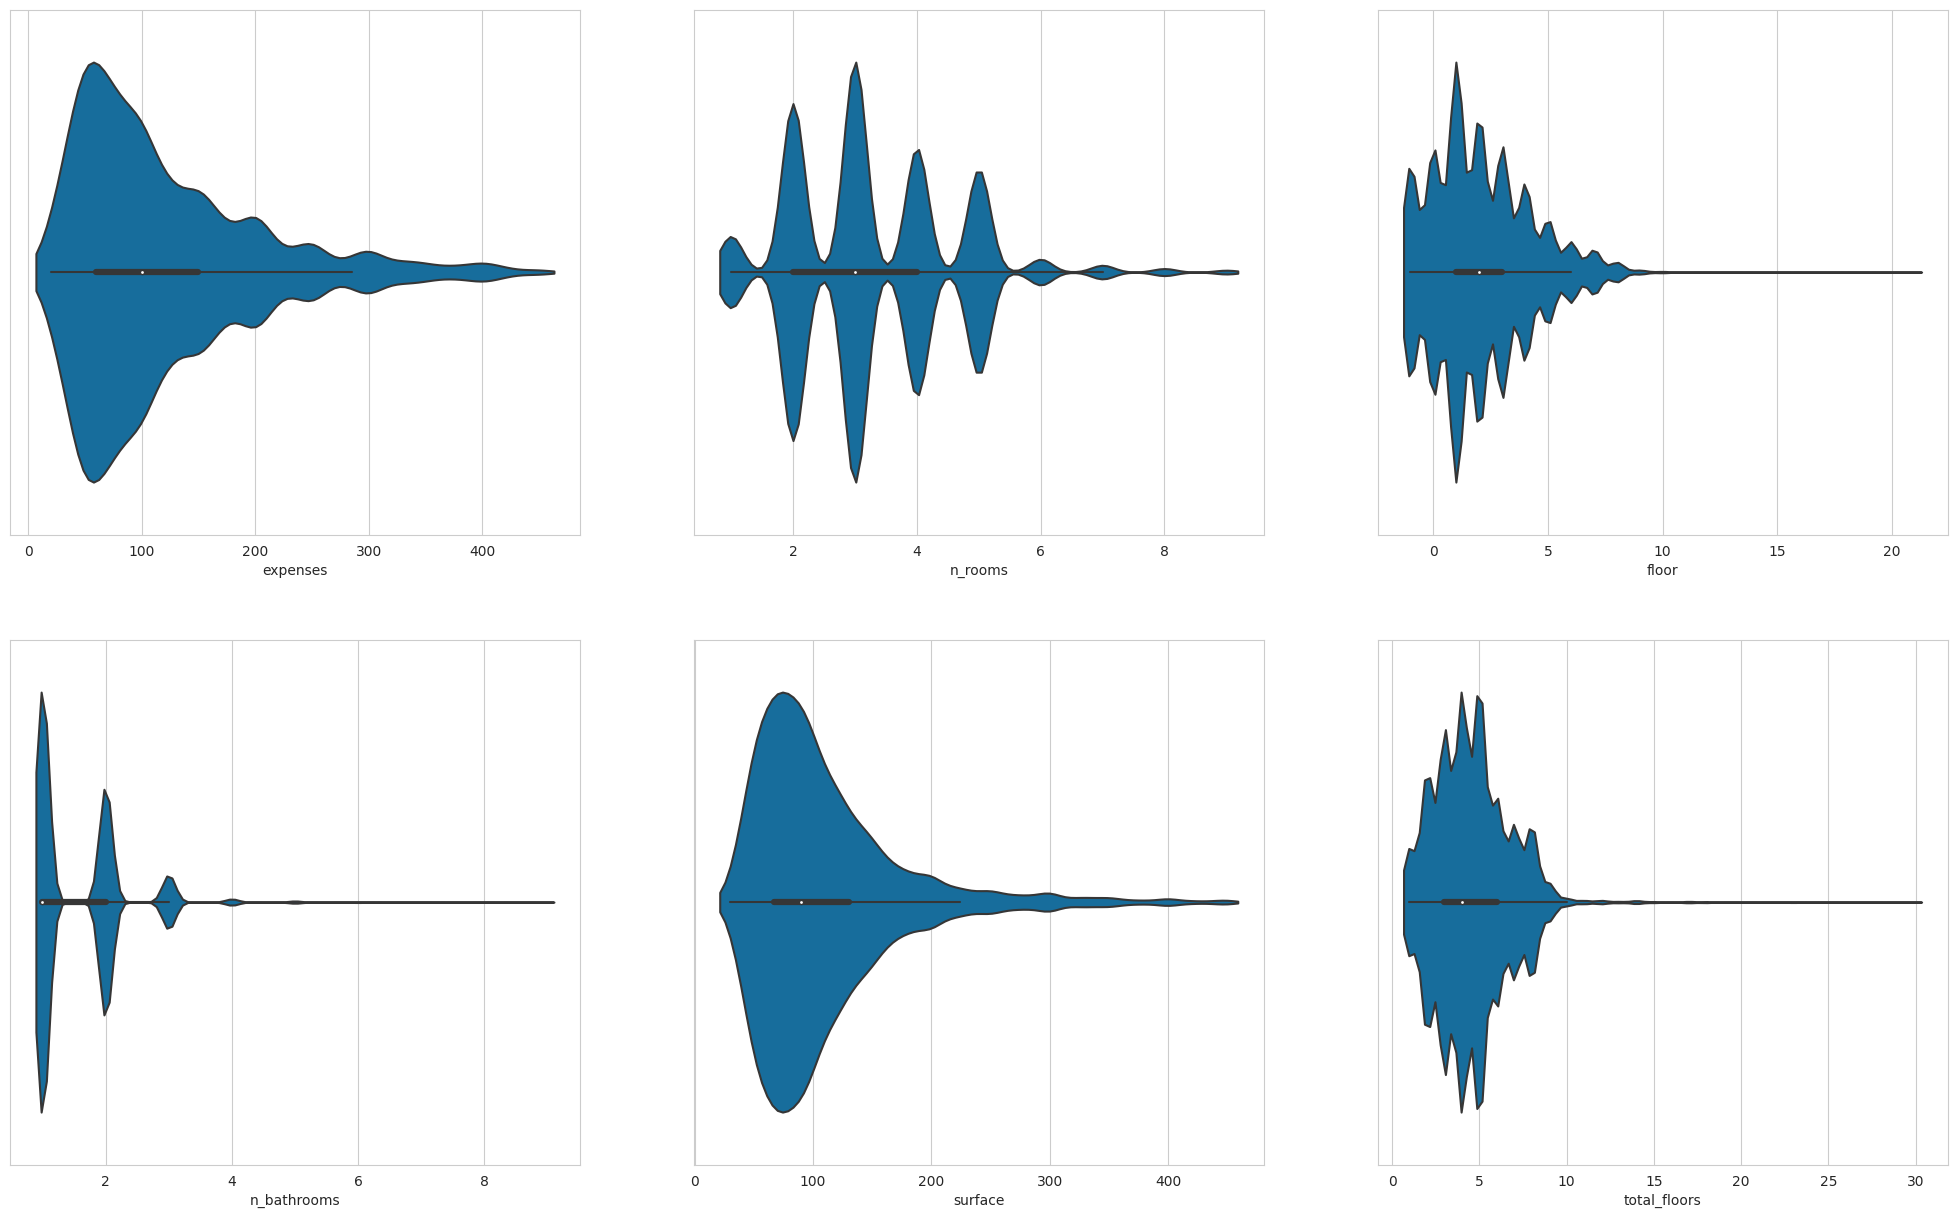

In [53]:
cont_vars = ['expenses', 'surface', 'floor', 'n_bathrooms', 'n_rooms', "total_floors"]

fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(25,15))
for i, col in enumerate(cont_vars):
  sns.violinplot(data=df_test,
                x=col,
                scale='count',
                ax=ax[i%2,i%3],
                cut=1)

In [54]:
imputed_test = df_test.copy()
imputed_test.isna().sum()

id                         0
balcony                    0
construction_year       6082
expenses                9738
floor                    898
garden                     0
n_bathrooms                0
elevator                   0
total_floors            7941
n_rooms                  141
surface                  641
buono_stato                0
ottimo                     0
nuovo                      0
da_ristrutturare           0
missing_cond               0
in_rome                    0
in_milan                   0
in_venice                  0
missing_loc                0
city_center_distance       0
dtype: int64

In [55]:
imp = IterativeImputer(random_state=42,
                      estimator = LinearRegression(), sample_posterior=False,max_iter=10,tol=0.001,
                      n_nearest_features = None, 
                      min_value = [20, -1, 1, 1400, 1, 30, 0, 0, 0, 1, 0], max_value=(450,20,29,2023,9,450,1,1,1,9,1), initial_strategy="mean", imputation_order = "roman")
cols_to_impute = ["expenses", "floor", "total_floors", "construction_year", "n_rooms", "surface", "in_rome", "in_milan", "in_venice", "n_bathrooms", "elevator"]
#The columns to impute together were chosen from the correlation heatmap

imputed_test[cols_to_impute] = imp.fit_transform(imputed_test[cols_to_impute])
#imp.fit(imputed_df[cols_to_impute_together])

#imputed_df[cols_to_impute_together] = imp.transform(imputed_df[cols_to_impute_together])

#Now, I will impute the construction_year based on all the other columns, as it by itself doesn't have direct relationships with other columns.

#imp.fit(imputed_df)
#imputed_df["construction_year"] = imp.transform(imputed_df[["construction_year"]])
#imputed_df.describe()

In [56]:
imputed_test["age"] = 2023-imputed_test['construction_year']
imputed_test["age"] = (imputed_test["age"] - imputed_test["age"].mean()) / (imputed_test["age"].std())
imputed_test.drop(["construction_year"], axis = 1, inplace = True)

In [57]:
imputed_test.describe()

,id,balcony,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,surface,...,ottimo,nuovo,da_ristrutturare,missing_cond,in_rome,in_milan,in_venice,missing_loc,city_center_distance,age
count,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,...,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,19788.000000,1.978800e+04
mean,33365.088589,0.659794,119.672140,1.979827,0.320649,1.524055,0.593238,4.325284,3.278075,109.069478,...,0.227208,0.156155,0.122650,0.025824,0.530928,0.309379,0.159187,0.000505,0.049537,-1.515307e-16
std,19116.407515,0.473790,79.561489,2.117229,0.466738,0.749709,0.491242,1.982127,1.327658,64.371254,...,0.419039,0.363012,0.328043,0.158613,0.499055,0.462249,0.365860,0.022475,0.234430,1.000000e+00
min,2.000000,0.000000,20.000000,-1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.312459e+00
25%,16763.500000,0.000000,60.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,67.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.345536e-01
50%,33446.500000,1.000000,100.000000,2.000000,0.000000,1.000000,1.000000,4.000000,3.000000,90.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.028411e-01
75%,49934.250000,1.000000,158.007741,3.000000,1.000000,2.000000,1.000000,5.323462,4.000000,130.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.747721e-01
max,66154.000000,1.000000,450.000000,21.000000,1.000000,9.000000,1.000000,30.000000,9.000000,450.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.694587,9.444500e+00


### We split our training dataset into train and validation sets, and then tune the hyperparameters using Weights and Biases


In [69]:

X = imputed_df.drop(['id', 'price'], axis=1)
y = imputed_df['price']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [59]:
wandb.login()

True

In [70]:
config = {
    "method": "random",
    "metric": {
      "name": "mse",
      "goal": "minimize"   
        },
    "parameters": { #define xgbm params
        "objective": {
            "values": ['reg:squarederror',"reg:gamma"] 
            },
        "n_estimators": {
            "distribution": "q_log_uniform",
            "min": 3,
            "max": 6,
            "q": 1
            },
        "learning_rate": {
            "distribution": 'log_uniform',
            "min": -4,
            "max": -0.01,
            },
        "min_split_gain": {
            "distribution": 'uniform',
            "min": 0,
            "max": 7,
            },
        "min_child_weight": {
            "distribution": 'uniform',
            "min": 0,
            "max": 5,
            },
        "subsample": {
            "distribution": 'uniform',
            "min": 0.3,
            "max": 1,
            },
        "colsample_bytree": {
            "distribution": 'uniform',
            "min": 0.3,
            "max": 1,
            },
        "reg_lambda": { #ridge penalty
            "distribution": 'uniform',
            "min": 0,
            "max": 5
            },
        "max_depth": {
            "distribution": 'q_uniform',
            "min": 1,
            "max": 8,
            "q": 1
            }
          }
        }
        

In [71]:
def train_xgb():
  config_defaults = {"objective" : 'reg:squarederror',
                      "n_estimators" : 100,
                      "learning_rate" : 0.1,
                      "min_split_gain" : 0,
                      "min_child_weight" : 0,
                      "subsample" : 1,
                      "colsample_bytree" : 1,
                      "reg_lambda" : 0,
                      "max_depth" : 1
                     }


  wandb.init(config=config_defaults, resume=False)  # defaults are over-ridden during the sweep
  config = wandb.config

  #update parameters
  params = {'objective': config.objective,
            'n_estimators': config.n_estimators,
            'learning_rate': config.learning_rate,
            'min_split_gain': config.min_split_gain,
            'min_child_weight': config.min_child_weight,
            'subsample': config.subsample,
            'colsample_bytree': config.colsample_bytree,
            'reg_lambda': config.reg_lambda,
            'max_depth': config.max_depth,
        }
  
  #instantiate and fit the model
  model = XGBModel(**params)
  model.fit(X_train, y_train)

  #predict
  preds = model.predict(X_val)

  #score
  mse = mean_squared_error(y_val, preds)

  #log the score to weights and biases
  wandb.log({"mse": mse})

In [62]:
import os
os.environ["WANDB_SILENT"] = "true" #Keep training silet to prevent notebook lag
sweep_id = wandb.sweep(config, project = "xgb_model_ML") #generate sweep id
wandb.agent(sweep_id,train_xgb, project = "xgb_model_ML") #launch sweep

Create sweep with ID: y4po6l71
Sweep URL: https://wandb.ai/tulgatemel/xgb_model_ML/sweeps/y4po6l71


### Now, we train our XGB Model with the optimized parameters

In [72]:
xgb_model = XGBRegressor(colsample_bytree=0.8906,
    learning_rate=0.02241,
    max_depth=8,
    min_child_weight=1.273,
    min_split_gain=1.777,
    n_estimators=362,
    objective= "reg:squarederror",
    reg_lambda=0.6925,
    subsample=0.5073,
    random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)
# Make predictions on the validation set
y_pred = xgb_model.predict(X_val)

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

[18:34:08] WARNING: ../src/learner.cc:767: 
Parameters: { "min_split_gain" } are not used.

Mean Squared Error: 49616282205.38955


#### We save the predictions

In [73]:
y_pred_test = xgb_model.predict(imputed_test.drop("id", axis=1))
submission_new = pd.DataFrame({
    "id": imputed_test["id"],
    "price": y_pred_test
})


In [75]:
submission_new.to_csv("submission_tugi2.csv",index=False)

Let's try the random forest model:


In [80]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict the target variable on the testing data
y_pred_rf = rf_model.predict(X_val)

# Evaluate the performance of the model using the mean squared error (MSE)
mse = mean_squared_error(y_val, y_pred_rf)
print(f'Mean Squared Error(random forest): {mse}')

y_pred_rf_test = rf_model.predict(imputed_test.drop("id", axis = 1))

submission_rf = pd.DataFrame({
    "id": imputed_test["id"],
    "price": y_pred_rf_test
})

submission_rf.to_csv("submission_rf_last.csv", index = False)

Mean Squared Error(random forest): 50390403449.98874
